In [13]:
# Create the network
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from sklearn.model_selection import train_test_split


point_count = 60
cloud_count = 20000

class PointNet1D(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PointNet1D, self).__init__()
        self.conv1 = nn.Conv1d(input_dim, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_dim)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
        self.bn6 = nn.BatchNorm1d(output_dim)
        
        self.drop = nn.Dropout(p=0.3)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = F.relu(self.bn4(self.fc1(x)))
        x = F.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        #x = F.relu(self.drop(x))
        x = F.relu(self.bn6(self.drop(x)))
        #x = torch.sigmoid(self.bn6(self.drop(x)))
        #x = F.softmax(x, dim=1)
        return torch.sigmoid(x)

net = PointNet1D(point_count, 1)

In [2]:
# Function to calculate Q
def charfun(x, y, R):
    if np.linalg.norm(np.absolute((x-y)), 1) <= R:
        return 1
    return 0

# Create clouds
R = 1     #What do different values of R change?
X_train, X_test = [],[] #torch.tensor(()), torch.tensor(())#torch.empty((point_count,2)), torch.empty((1,1))
y_train, y_test = [], [] #torch.Tensor([]), torch.Tensor([])
i, k  = 0, 0

for k in range(cloud_count):
    if i == 0:
        i = 1
        x = np.random.normal(loc=.5, scale=0.5, size=(point_count, 3))
    else:
        x = np.random.uniform(low=0, high=1.0, size=(point_count, 3))
        i = 0
    Q = sum(charfun(k, j, R) for k in x for j in x)
    Q *= 1/(len(x)**2)
    #print(Q)
    if k < cloud_count * 0.8:
        X_train.append(x)
        y_train.append(Q)
        k += 1
    else:

        X_test.append(x)
        y_test.append(Q)

#Turn data in torch tensor
X_train = torch.Tensor(X_train)
y_train =  torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)


## Reshape data for network
y_train.unsqueeze_(1)
y_test.unsqueeze_(1)
print(X_train.size(), y_train.size())

#Training set batches
trainset = TensorDataset(X_train, y_train)
#print(trainset)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2, drop_last = True)
#print(y_test)
print(X_test.size(), y_test.size())
#Test set batches
#testset = TensorDataset(X_test, y_test)

#testloader = torch.utils.data.DataLoader(testset, batch_size=32,
#                                          shuffle=True, num_workers=2,  drop_last = True)

torch.Size([16000, 60, 3]) torch.Size([16000, 1])
torch.Size([4000, 60, 3]) torch.Size([4000, 1])


In [3]:
# Loss function and optimizer
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Functions to find loss and accuracy
def find_loss():
    output = net(X_test)
    val_loss = criterion(output, y_test)
    return val_loss.item()

def accuracy_fun(output, labels):
    total, correct = 0.0 , 0
    for i in range(len(y_test)):
        if abs(output[i].item() - labels[i].item()) < 2 * R/5:  # This is very generous and crudge to measure the accuracy
            correct += 1
        total += 1
    return 100 * correct / total

In [14]:
# Training
training_loss = []
validep_loss = []
trainingep_loss = []
validation_loss = []
#accuracy = []
for epoch in range(30):  # loop over the dataset multiple times
    ep_counter, ep_loss = 0, 0.0
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss.append(loss.detach().item())
        
        # print statistics
        running_loss += loss.item()
        ep_loss += loss.item()
        ep_counter += 1
        if i % 32 == 31:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 32))
            training_loss.append(running_loss / 32)
            running_loss = 0.0
            #accuracy.append(accuracy_fun(outputs, labels))
        validation_loss.append(find_loss())
        
    validep_loss.append(find_loss())
    trainingep_loss.append(ep_loss/ep_counter)
    ep_counter, ep_loss = 0, 0.0

print('Finished Training')

[1,    32] loss: 0.088
[1,    64] loss: 0.086
[1,    96] loss: 0.089
[1,   128] loss: 0.089
[1,   160] loss: 0.087
[1,   192] loss: 0.092
[1,   224] loss: 0.087
[1,   256] loss: 0.089
[1,   288] loss: 0.084
[1,   320] loss: 0.086
[1,   352] loss: 0.085
[1,   384] loss: 0.088
[1,   416] loss: 0.084
[1,   448] loss: 0.089
[1,   480] loss: 0.085
[2,    32] loss: 0.084
[2,    64] loss: 0.087
[2,    96] loss: 0.092
[2,   128] loss: 0.088
[2,   160] loss: 0.089
[2,   192] loss: 0.085
[2,   224] loss: 0.090
[2,   256] loss: 0.086
[2,   288] loss: 0.083
[2,   320] loss: 0.089
[2,   352] loss: 0.091
[2,   384] loss: 0.087
[2,   416] loss: 0.087
[2,   448] loss: 0.088
[2,   480] loss: 0.087
[3,    32] loss: 0.085
[3,    64] loss: 0.090
[3,    96] loss: 0.087
[3,   128] loss: 0.089
[3,   160] loss: 0.085
[3,   192] loss: 0.086
[3,   224] loss: 0.089
[3,   256] loss: 0.086
[3,   288] loss: 0.086
[3,   320] loss: 0.090
[3,   352] loss: 0.089
[3,   384] loss: 0.086
[3,   416] loss: 0.085
[3,   448] 

[24,    96] loss: 0.084
[24,   128] loss: 0.088
[24,   160] loss: 0.087
[24,   192] loss: 0.087
[24,   224] loss: 0.085
[24,   256] loss: 0.091
[24,   288] loss: 0.092
[24,   320] loss: 0.090
[24,   352] loss: 0.087
[24,   384] loss: 0.084
[24,   416] loss: 0.088
[24,   448] loss: 0.088
[24,   480] loss: 0.088
[25,    32] loss: 0.085
[25,    64] loss: 0.091
[25,    96] loss: 0.085
[25,   128] loss: 0.084
[25,   160] loss: 0.093
[25,   192] loss: 0.088
[25,   224] loss: 0.090
[25,   256] loss: 0.088
[25,   288] loss: 0.083
[25,   320] loss: 0.085
[25,   352] loss: 0.089
[25,   384] loss: 0.086
[25,   416] loss: 0.086
[25,   448] loss: 0.087
[25,   480] loss: 0.087
[26,    32] loss: 0.083
[26,    64] loss: 0.092
[26,    96] loss: 0.086
[26,   128] loss: 0.085
[26,   160] loss: 0.085
[26,   192] loss: 0.088
[26,   224] loss: 0.086
[26,   256] loss: 0.085
[26,   288] loss: 0.085
[26,   320] loss: 0.091
[26,   352] loss: 0.087
[26,   384] loss: 0.089
[26,   416] loss: 0.087
[26,   448] loss

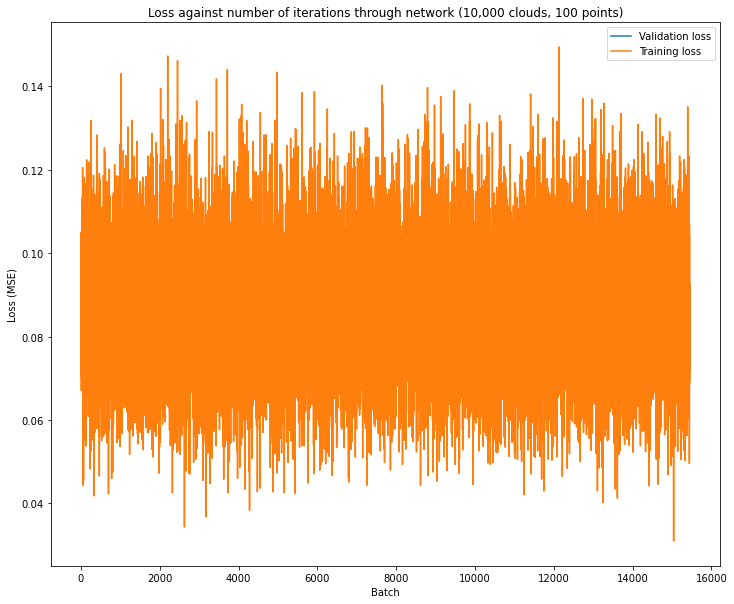

In [16]:
# Print out relevant graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.title('Loss against number of iterations through network (10,000 clouds, 100 points)') 
plt.xlabel('Batch')                                              
plt.ylabel('Loss (MSE)') 
plt.plot(validation_loss, label = "Validation loss")
plt.plot(training_loss, label = "Training loss")
plt.legend()

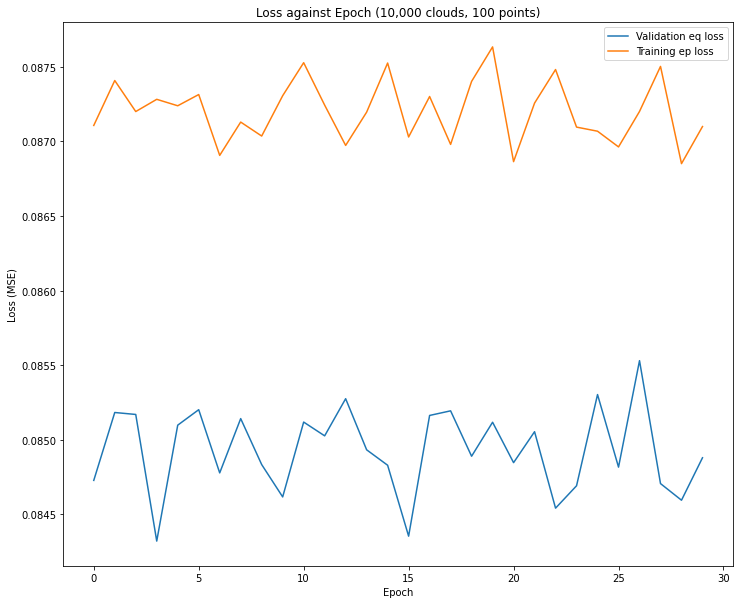

In [17]:
# And another one
plt.figure(figsize=(12,10))
plt.title('Loss against Epoch (10,000 clouds, 100 points)') 
plt.xlabel('Epoch')                                              
plt.ylabel('Loss (MSE)') 
plt.plot(validep_loss, label = "Validation eq loss")
plt.plot(trainingep_loss, label = "Training ep loss")
plt.legend()

In [18]:
from sklearn.metrics import r2_score as r2
r2(y_test.detach().numpy(), outputs.detach().numpy())

-1.8703047135408766

In [19]:
print(outputs[1:5], y_test[1:5])

tensor([[0.5000],
        [0.5000],
        [0.7118],
        [0.6485]], grad_fn=<SliceBackward>) tensor([[0.5372],
        [0.1861],
        [0.5172],
        [0.1839]])


In [20]:
print(1-(1-r2(y_test.detach().numpy(), outputs.detach().numpy()))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

-1.9140260343868913
